# Pixel Sides

Este é um projeto para a disciplina de Aprendizado de Máquina do DCC/UFMG em 2021/1, ministrada por Adriano Veloso.
Autor: Flávio Coutinho <fegemo@cefetmg.br>

A ideia é, dada a imagem frontal de um personagem em pixel art (64x64), gerar as visões laterais e de costas dele.

Foi usado o _dataset_ Tiny Pixel ....

A implementação usa Pix2Pix... ou ...CycleGAN?

Passos:
1. Criar um classificador de pose usando _transfer learning_ de MobileNET v2?
1. Criar uma DCGAN?
1. Treinar Pix2Pix?
1. Treinar CycleGAN?

In [98]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print("Versão do TensorFlow: ", tf.__version__)

Versão do TensorFlow:  2.5.0


In [199]:
seed = 42
np.random.seed(seed)

data_folder = "tiny-hero"
batch_size = 100 
image_size = 64

channels = 3

#latent_size = 40
#condition_size = 10
#feature_map_size = 64
#num_epochs = 200

#lr_d = 0.0004
#lr_g = 0.0001
#beta1 = 0.5
#ngpu = 1


## 1. Criando o _dataset_ para classificador

In [63]:
X_train = tf.keras.preprocessing.image_dataset_from_directory(
  data_folder,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(image_size, image_size),
  batch_size=batch_size)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
  data_folder,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(image_size, image_size),
  batch_size=batch_size)


Found 3648 files belonging to 4 classes.
Using 2919 files for training.
Found 3648 files belonging to 4 classes.
Using 729 files for validation.


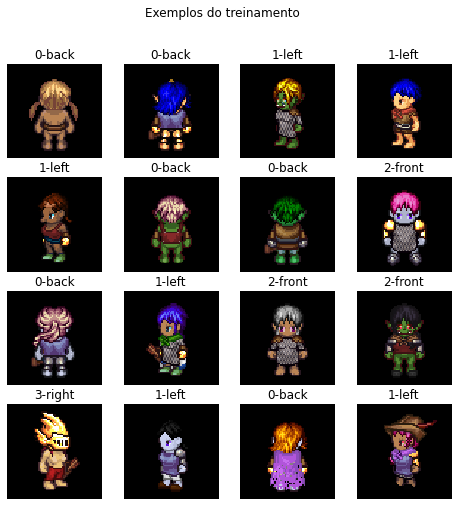

In [64]:
class_names = X_train.class_names

plt.figure(figsize=(8, 8))
plt.suptitle("Exemplos do treinamento")
for images, labels in X_train.take(1):
    for i in range(4):
        for j in range(4):
            ax = plt.subplot(4, 4, (i*4+j)+1)
            plt.imshow(images[i*4+j].numpy().astype("uint8"), interpolation="nearest")
            plt.title(class_names[labels[i*4+j]])
            plt.axis("off")
            
X_train = X_train.cache().shuffle(1000, seed=seed).prefetch(buffer_size=tf.data.AUTOTUNE)
X_validation = X_validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [65]:
pose_classifier = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
    layers.Conv2D(2, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(4, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(24),
    layers.Dense(len(class_names), activation="softmax")
])

pose_classifier.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

pose_classifier.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 2)         56        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 4)         76        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 4)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)               

In [66]:
epochs = 10
history = pose_classifier.fit(
  X_train,
  validation_data=X_validation,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 2s 19ms/step - loss: 0.8327 - accuracy: 0.7619 - val_loss: 0.3009 - val_accuracy: 0.9671
Epoch 2/10
30/30 [==============================] - 0s 9ms/step - loss: 0.1619 - accuracy: 0.9753 - val_loss: 0.0710 - val_accuracy: 0.9877
Epoch 3/10
30/30 [==============================] - 0s 9ms/step - loss: 0.0511 - accuracy: 0.9914 - val_loss: 0.0292 - val_accuracy: 0.9973
Epoch 4/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0327 - accuracy: 0.9918 - val_loss: 0.0238 - val_accuracy: 0.9931
Epoch 5/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0188 - accuracy: 0.9966 - val_loss: 0.0114 - val_accuracy: 0.9973
Epoch 6/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0130 - accuracy: 0.9983 - val_loss: 0.0080 - val_accuracy: 0.9973
Epoch 7/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0104 - accuracy: 0.9983 - val_loss: 0.0069 - val_accuracy: 0.9973
Epoch 8/10
30/3

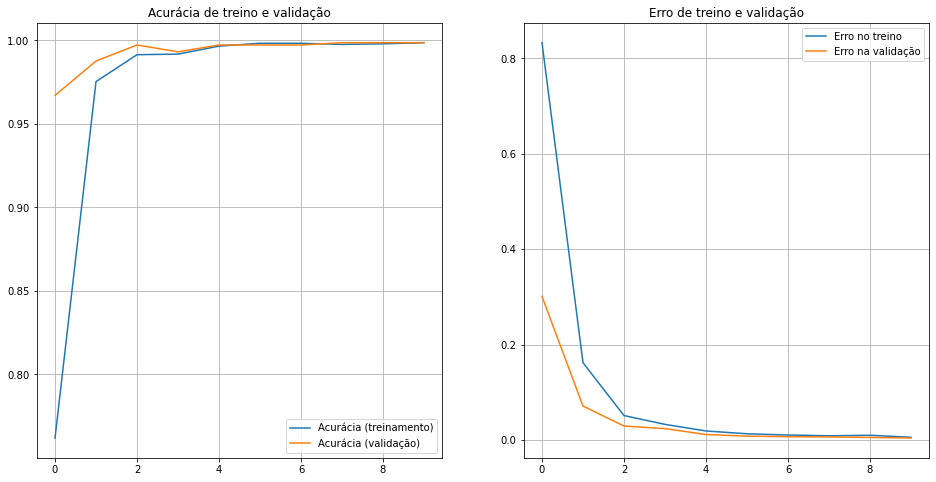

In [67]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Acurácia (treinamento)")
plt.plot(epochs_range, val_acc, label="Acurácia (validação)")
plt.legend(loc="lower right")
plt.grid()
plt.title("Acurácia de treino e validação")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Erro no treino")
plt.plot(epochs_range, val_loss, label="Erro na validação")
plt.legend(loc="upper right")
plt.title("Erro de treino e validação")
plt.grid()
plt.show()

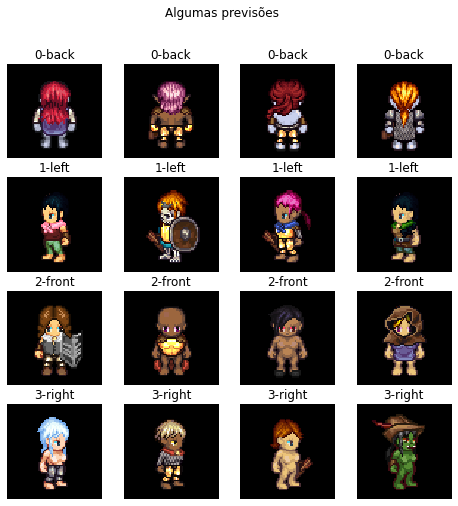

In [201]:
Y_predicted = np.argmax(pose_classifier.predict(X_validation), axis=1).astype(int).reshape(729, 1)
X_validation_unbatched = np.stack(X_validation.unbatch().as_numpy_iterator())
X_validation_unbatched = np.concatenate((X_validation_unbatched, Y_predicted), axis=1)

X_validation_by_class = dict()
for c, (image, y, y_hat) in enumerate(X_validation_unbatched):
    if y_hat not in X_validation_by_class:
        X_validation_by_class[y_hat] = []
    X_validation_by_class[y_hat].append((image, y, y_hat))

plt.figure(figsize=(8, 8))
plt.suptitle("Algumas previsões")
for i, class_name in enumerate(class_names):
    indices = np.arange(len(X_validation_by_class[i]), dtype="int")
    indices = np.random.choice(indices, size=4)
    examples_from_current_class = np.array(X_validation_by_class[i], dtype=object)[indices]
    for j in range(4):
        ax = plt.subplot(4, 4, (i*4+j)+1)
        plt.imshow(examples_from_current_class[j][0].astype("uint8"), interpolation="nearest")
        plt.title(class_names[examples_from_current_class[j][2]])
        plt.axis("off")
